## Imports and Configuration

In [1]:
import numpy as np
import pyvista as pv

from eikonax import preprocessing, solver, tensorfield

pv.global_theme.jupyter_backend = "static"

## Load Mesh Data

In [2]:
mesh_data = np.load("left_atrium_surface.npz")
vertices = mesh_data["vertices"]
simplices = mesh_data["simplices"]

## Configure Problem and Solver

In [3]:
solver_data = solver.SolverData(
    tolerance=1e-6,
    max_num_iterations=1000,
    max_value=1000,
    loop_type="jitted_while",
    use_soft_update=False,
    softminmax_order=100,
    softminmax_cutoff=0.01,
)
initial_sites = preprocessing.InitialSites(inds=(300,), values=(0,))
parameter_vector = np.ones(simplices.shape[0])

## Set up Mesh and Tensor Field

In [4]:
mesh_data = preprocessing.MeshData(vertices, simplices)
tensor_on_simplex = tensorfield.InvLinearScalarSimplexTensor(dimension=vertices.shape[1])
tensor_field_mapping = tensorfield.LinearScalarMap()
tensor_field_object = tensorfield.TensorField(
    num_simplices=simplices.shape[0],
    vector_to_simplices_map=tensor_field_mapping,
    simplex_tensor=tensor_on_simplex,
)

## Solve Forward Problem

In [5]:
tensor_field_instance = tensor_field_object.assemble_field(parameter_vector)
eikonal_solver = solver.Solver(mesh_data, solver_data, initial_sites)
solution = eikonal_solver.run(tensor_field_instance)

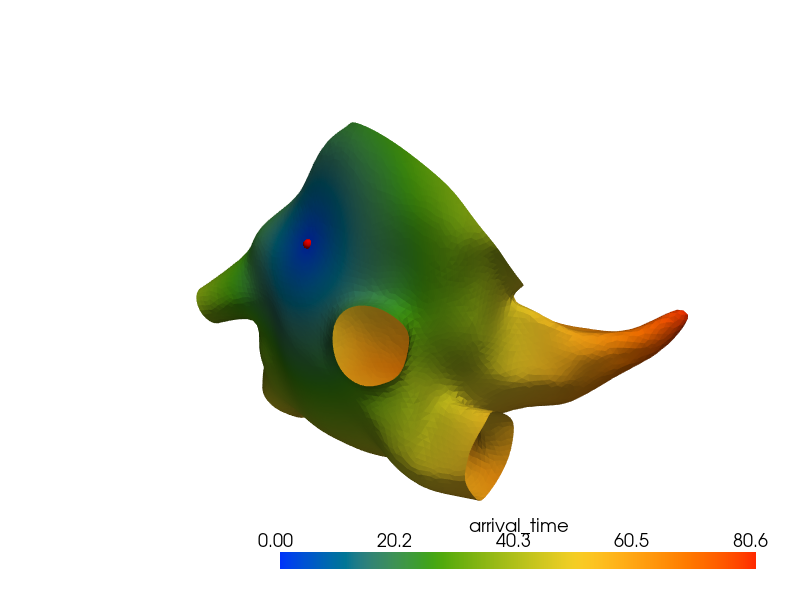

In [6]:
camera_position = [
    (188.47637815695606, -98.0464167693063, -18.87996870464967),
    (5.789453506469723, -8.405534744262697, 10.9196138381958),
    (-0.19185964574715458, -0.6387160568447591, 0.745138695185305),
]
pv_mesh = pv.PolyData.from_regular_faces(vertices, simplices)
pv_mesh.point_data["arrival_time"] = solution.values
plotter = pv.Plotter()
plotter.add_mesh(
    pv_mesh, scalars="arrival_time", cmap="rainbow", show_edges=False, show_scalar_bar=True
)
plotter.add_points(
    vertices[initial_sites.inds[0]], color="red", point_size=10, render_points_as_spheres=True
)
plotter.show(window_size=[800, 600], cpos=camera_position)